# Phase d’apprentissage

In [1]:
import re as r 
import numpy as np
from matplotlib import pyplot

In [2]:
np.random.seed(488)

### Lecture des fichiers

In [3]:
def read_pgm(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = r.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

### Transformation chaque matrice en une ligne de taille 4096 et regroupement des résultats dans une matrice X de taille 100×4096

In [4]:
indices = np.random.choice(range(1, 1680), 100, replace=False)
X = np.empty((0, 4096))
for i in indices:
    path = "./FG1/visage (" + str(i) + ").pgm"
    image = read_pgm(path, byteorder='<')
    # Transformation chaque matrice en une ligne de taille 4096.
    image = image.reshape(1, 4096)
    # Regroupement les résultats dans une matrice X de taille 100×4096.
    X = np.append(X, image, axis=0)

print(X.shape)
print(X)

(100, 4096)
[[113. 114. 116. ...  27.  23.  30.]
 [202. 199. 200. ... 153. 188. 194.]
 [ 98. 117. 141. ...  37.  41.  33.]
 ...
 [130. 152. 154. ... 102. 110. 116.]
 [ 96. 126. 139. ...   3.   3.   3.]
 [ 96.  94.  98. ... 120. 121. 122.]]


### Normalisation de X et conservation des moyennes et des écarts types

In [5]:
X_mean = np.mean(X, axis=0)
X_mean = X_mean.reshape(1, 4096)
X_std = np.std(X, axis=0)
X_std = X_std.reshape(1, 4096)

In [6]:
# Normalisation de X.
Y = (X - X_mean)/X_std

In [7]:
# Conservation des moyennes et des écarts types.
M = np.empty((0, 4096))
M = np.append(M, X_mean, axis=0)
M = np.append(M, X_std, axis=0)
print(M.shape)
M

(2, 4096)


array([[110.48      , 114.61      , 117.3       , ...,  98.31      ,
         99.7       ,  99.51      ],
       [ 50.19909959,  50.97565988,  51.68761941, ...,  52.8060025 ,
         54.65208139,  56.57163512]])

### Décomposition en valeurs singulières de Y

In [8]:
U, S, V_T = np.linalg.svd(Y, full_matrices=False)

In [9]:
S = np.diag(S)

On a $Y = USV^T \implies Y^T = VSU^T$ et $Y^TY = PDP^T$ donc $Y^TY=VS(U^TU)SV^T = VS^2V^T$. Par identification, $P=V$ et $D=S^2$.

In [10]:
D = S @ S
P = np.transpose(V_T)
print(D.shape)
P.shape

(100, 100)


(4096, 100)

### Choix du nombre k de composantes à retenir entre 50 et 70

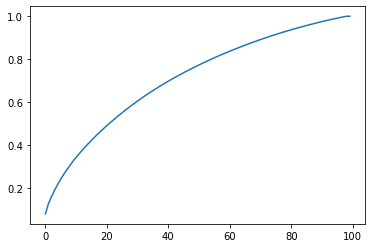

In [11]:
total = sum(sum(S))
choice = np.cumsum(sum(S))
k = choice/total
pyplot.plot(k)
pyplot.show()

In [12]:
k[65]

0.8656589933869373

On va choisir un $k = 65$ parce que ça représente 86% de la variance. C'est une heuristique donc il n'y pas une justification directe pour ce choix.

**S'il y avait un moyen de quantifier la précision sur la base de données d'évaluation, on pourrait alors choisir un $k$ tel que la précision est maximale.**

In [13]:
r = 55
P_r = P[:, 0:r]
Z = Y @ P_r

Le gain en mémoire est alors $1-\frac{65}{100}=35\%$.

# Phase d'évaluation

In [14]:
import re as r 
import numpy as np
from matplotlib import pyplot

In [15]:
# Transformation chaque matrice en une ligne de taille 4096.
# Regroupement les résultats dans une matrice X_test de taille 100×4096.
X_test = np.empty((0, 4096))
for i in range(1, 101):
    path = "./FG2/visage (" + str(i) + ").pgm"
    image = read_pgm(path, byteorder='<')
    # Transformation chaque matrice en une ligne de taille 4096.
    image = image.reshape(1, 4096)
    # Regroupement les résultats dans une matrice X_test de taille 100×4096.
    X_test = np.append(X_test, image, axis=0)
print(X_test.shape)
X_test

(100, 4096)


array([[122., 128., 130., ...,  69.,  67.,  66.],
       [ 90., 112., 132., ..., 169., 209., 235.],
       [ 48.,  59.,  65., ...,  89.,  95.,  92.],
       ...,
       [ 69.,  81.,  72., ..., 226., 193., 164.],
       [133., 155., 164., ...,  63.,  62.,  65.],
       [ 53.,  56.,  59., ...,  62.,  64.,  72.]])

### Reconnaisance faciale sans seuil

In [16]:
def find_match(i):
    # Lecture de l’image et transformation de la matrice 64 × 64 en une ligne 4096 =⇒ x_test
    x_test = X_test[i,:]
    
    # Normalisation de cette image, c’est à dire centrage et réduction =⇒ y_test
    y_test = (x_test - M[0])/M[1]
    
    # Coordonnées de cette image dans la base des composantes principales retenues
    z_test = y_test @ P_r
    
    # Calcul des distances entre la nouvelle image et celles de la BDD
    
    # Identification du visage par la recherche de la distance minimale
    d_test = np.linalg.norm(z_test)
    
    # Initiatialiseation d'une distance aléatoire et mettre à jour à chaque fois
    d_min = abs(d_test - np.linalg.norm(Z[5, :]))
    
    for j in range(0, 100):
        d = np.linalg.norm(Z[j, :])
        d_loop = abs(d - d_test)
        if (d_loop < d_min):
            d_min = d_loop
            index = j
    print("L'image " + str(i) + " de la base d'évaluation ressemble à l'image " + str(index) + " de la base d'entraînement.")
    path_training = "./FG1/visage (" + str(index) + ").pgm"
    path_test = "./FG2/visage (" + str(i) + ").pgm"
    image_training = read_pgm(path_training, byteorder='<')
    image_test = read_pgm(path_test, byteorder='<')    
    pyplot.imshow(image_training, pyplot.cm.gray)
    pyplot.show()
    pyplot.imshow(image_test, pyplot.cm.gray)
    pyplot.show()

L'image 23 de la base d'évaluation ressemble à l'image 11 de la base d'entraînement.


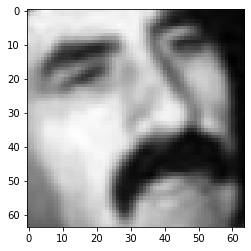

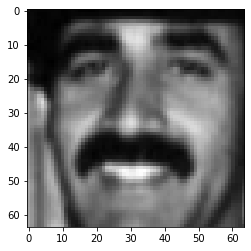

In [17]:
find_match(23)

L'image 21 de la base d'évaluation ressemble à l'image 13 de la base d'entraînement.


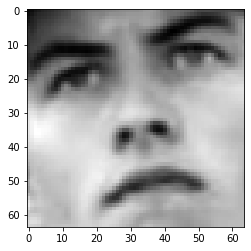

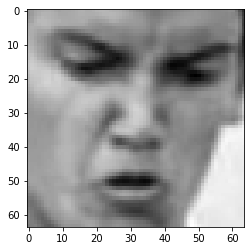

In [18]:
find_match(21)

L'image 11 de la base d'évaluation ressemble à l'image 19 de la base d'entraînement.


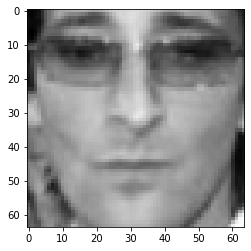

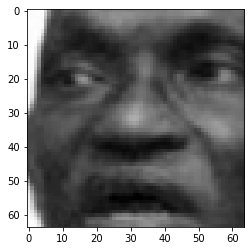

In [19]:
find_match(11)

**On remarque qu'avec cette méthode, on arrive à voir beaucoup d'images qui ne sont pas similaires. La raison est qu'il n'y pas de critère pour quantifier cette similarité. Pour remédier à cela, on ajoutera un seuil.**

### Reconnaisance faciale avec seuil

In [20]:
def find_match_seuil(i, seuil):
    # Lecture de l’image et transformation de la matrice 64 × 64 en une ligne 4096 =⇒ x_test
    x_test = X_test[i,:]
    
    # Normalisation de cette image, c’est à dire centrage et réduction =⇒ y_test
    y_test = (x_test - M[0])/M[1]
    
    # Coordonnées de cette image dans la base des composantes principales retenues
    z_test = y_test @ P_r
    
    # Calcul des distances entre la nouvelle image et celles de la BDD
    
    # Identification du visage par la recherche de la distance minimale
    d_test = np.linalg.norm(z_test)
    
    # Initiatialiseation d'une distance aléatoire et mettre à jour à chaque fois
    d_min = abs(d_test - np.linalg.norm(Z[5, :]))
    for j in range(0, 100):
        d = np.linalg.norm(Z[j, :])
        d_loop = abs(d - d_test)
        if (d_loop < d_min):
            d_min = d_loop
            index = j
    if d_min < seuil:
        print("L'image " + str(i) + " de la base d'évaluation ressemble à l'image " + str(index) + " de la base d'entraînement.")
        path_training = "./FG1/visage (" + str(index) + ").pgm"
        path_test = "./FG2/visage (" + str(i) + ").pgm"
        image_training = read_pgm(path_training, byteorder='<')
        image_test = read_pgm(path_test, byteorder='<')    
        pyplot.imshow(image_training, pyplot.cm.gray)
        pyplot.show()
        pyplot.imshow(image_test, pyplot.cm.gray)
        pyplot.show()
    else:
        print("Il n'y pas de similarité!")

#### Chercher les similarité pour un seuil bien défini

L'image 23 de la base d'évaluation ressemble à l'image 11 de la base d'entraînement.


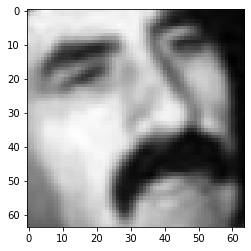

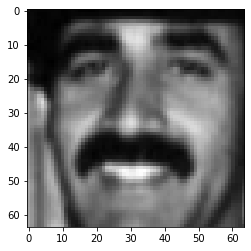

In [21]:
find_match_seuil(23, 1e-1)

L'image 21 de la base d'évaluation ressemble à l'image 13 de la base d'entraînement.


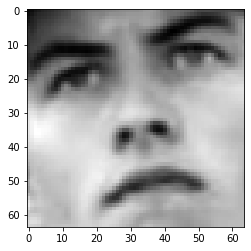

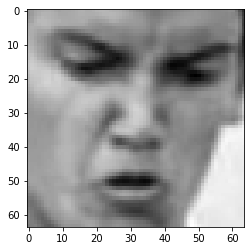

In [22]:
find_match_seuil(21, 1e-1)

In [23]:
find_match_seuil(11, 1e-1)

Il n'y pas de similarité!


### Observations

L'image 28 de la base d'évaluation ressemble à l'image 54 de la base d'entraînement.


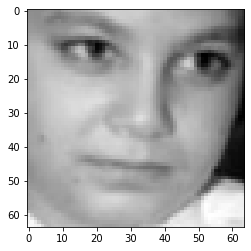

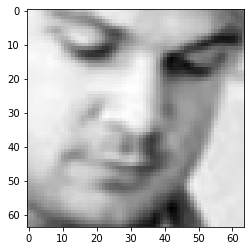

In [24]:
find_match_seuil(28, 1e-1)

L'image 83 de la base d'évaluation ressemble à l'image 25 de la base d'entraînement.


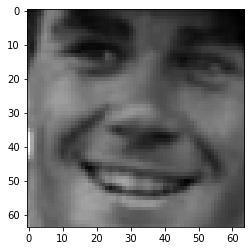

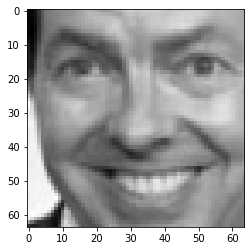

In [25]:
find_match_seuil(83, 1e-1)

L'image 16 de la base d'évaluation ressemble à l'image 3 de la base d'entraînement.


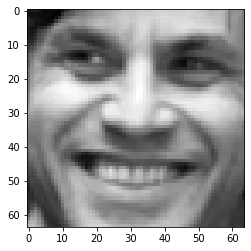

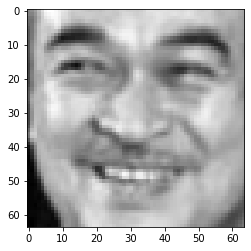

In [26]:
find_match_seuil(16, 1e-1)

L'image 34 de la base d'évaluation ressemble à l'image 14 de la base d'entraînement.


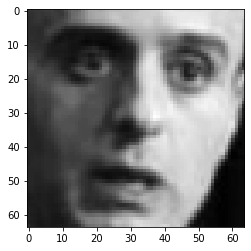

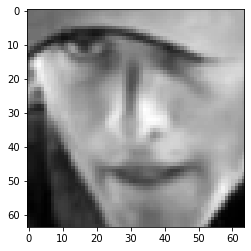

In [27]:
find_match_seuil(34, 1e-1)

**On observe que l'algorithme arrive à trouver quelques similarités entre les visages comme l'expression du visage, le sourire et autres.**